In [9]:
! pip install -U -q langchain_community arxiv tiktoken langchainhub pymilvus langchain langgraph tavily-python langchain-milvus langchain-google-genai beautifulsoup4 langchain-experimental neo4j json-repair langchain-openai sentence_transformers langchain-huggingface langchain_neo4j

# LangGraph GraphRAG agent with Google Gemini 2.0 and GPT4o

Made by: Wilfredo Aaron Sosa Ramos

Reference: https://github.com/milvus-io/bootcamp/blob/master/bootcamp/RAG/advanced_rag/langgraph-graphrag-agent-local.ipynb


Let's build an Advanced RAG with a GraphRAG agent that will run a combination of Google Gemini 2.0 and GPT4o. The idea is that we use GPT4o for advanced tasks, like generating the Neo4j query and Google Gemini 2.0 for the rest.

## Ideas

We'll combine ideas from three RAG papers into a RAG agent:

- **Routing:**  Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- **Fallback:** Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884.pdf)). Fallback to web search if docs are not relevant to query
- **Self-correction:** Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question

image.png

Note that this will incorperate [a few general ideas for agents](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/):

- **Reflection**: The self-correction mechanism is a form of reflection, where the LangGraph agent reflects on its retrieval and generations
- **Planning**: The control flow laid out in the graph is a form of planning
- **Tool use**: Specific nodes in the control flow (e.g., web search) will use tools

## Local models

### Env Variables
Variables needed in an .env file or loaded as variables at start:

Required:
```
OPENAI_API_KEY=sk-...
GOOGLE_API_KEY=...
TAVILY_API_KEY=tvly-...
NEO4J_URI=...
NEO4J_USERNAME=...
NEO4J_PASSWORD=...
```

### Search

Uses [Tavily](https://tavily.com/#api)

In [2]:
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [3]:
from langchain.globals import set_verbose, set_debug

set_debug(False)
set_verbose(False)

In [4]:
import arxiv

search_query = "agent OR 'large language model' OR 'prompt engineering' OR 'rag'"
max_results = 20

# Fetch papers from arXiv
client = arxiv.Client()
search = arxiv.Search(
    query=search_query, max_results=max_results, sort_by=arxiv.SortCriterion.Relevance
)

In [5]:
### Milvus Lite Vectorstore

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_milvus import Milvus
from langchain_community.embeddings import HuggingFaceEmbeddings


docs = []
for result in client.results(search):
    docs.append(
        {"title": result.title, "summary": result.summary, "url": result.entry_id}
    )

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.create_documents(
    [doc["summary"] for doc in docs], metadatas=docs
)

print(f"Number of papers: {len(docs)}")
print(f"Number of chunks: {len(doc_splits)}")


# Add to Milvus
vectorstore = Milvus.from_documents(
    documents=doc_splits,
    collection_name="rag_milvus",
    embedding=HuggingFaceEmbeddings(),
    connection_args={"uri": "./milvus_ingest.db"},
)
retriever = vectorstore.as_retriever()

Number of papers: 20
Number of chunks: 20


<ipython-input-5-91cbfc88fdb3>:30: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding=HuggingFaceEmbeddings(),
<ipython-input-5-91cbfc88fdb3>:30: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding=HuggingFaceEmbeddings(),


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-01-04 14:26:02,608 [ERROR][handler]: RPC error: [create_index], <MilvusException: (code=65535, message=invalid index type: HNSW, local mode only support FLAT IVF_FLAT AUTOINDEX: )>, <Time:{'RPC start': '2025-01-04 14:26:02.606991', 'RPC error': '2025-01-04 14:26:02.608778'}> (decorators.py:140)


In [6]:
retriever.invoke("What is a LLM?")

[Document(metadata={'pk': 455082184054145029, 'summary': "We propose a methodology that combines several advanced techniques in Large\nLanguage Model (LLM) retrieval to support the development of robust,\nmulti-source question-answer systems. This methodology is designed to integrate\ninformation from diverse data sources, including unstructured documents (PDFs)\nand structured databases, through a coordinated multi-agent orchestration and\ndynamic retrieval approach. Our methodology leverages specialized agents-such\nas SQL agents, Retrieval-Augmented Generation (RAG) agents, and router agents -\nthat dynamically select the most appropriate retrieval strategy based on the\nnature of each query. To further improve accuracy and contextual relevance, we\nemploy dynamic prompt engineering, which adapts in real time to query-specific\ncontexts. The methodology's effectiveness is demonstrated within the domain of\nContract Management, where complex queries often require seamless interaction

In [8]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash-exp', format="json", temperature=0)

In [10]:
import getpass
passsword = getpass.getpass("Enter the Neo4j instance password: ")

Enter the Neo4j instance password: ··········


In [11]:
# GraphRAG Setup
from langchain_neo4j.graphs.neo4j_graph import Neo4jGraph
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_experimental.graph_transformers.diffbot import DiffbotGraphTransformer
from langchain_openai import ChatOpenAI
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

graph = Neo4jGraph(
    url="neo4j+s://5ef68eae.databases.neo4j.io",
    username="neo4j",
    password=passsword,
    refresh_schema=False
)

graph_llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

graph_transformer = LLMGraphTransformer(
    llm=graph_llm,
    allowed_nodes=["Paper", "Author", "Topic"],
    node_properties=["title", "summary", "url"],
    allowed_relationships=["AUTHORED", "DISCUSSES", "RELATED_TO"],
)

graph_documents = graph_transformer.convert_to_graph_documents(doc_splits)

graph.add_graph_documents(graph_documents)

print(f"Graph documents: {len(graph_documents)}")
print(f"Nodes from 1st graph doc:{graph_documents[0].nodes}")
print(f"Relationships from 1st graph doc:{graph_documents[0].relationships}")

Graph documents: 20
Nodes from 1st graph doc:[Node(id='Rag_Playground', type='Paper', properties={'title': 'RAG Playground', 'summary': 'An open-source framework for systematic evaluation of Retrieval-Augmented Generation (RAG) systems, implementing and comparing three retrieval approaches: naive vector search, reranking, and hybrid vector-keyword search, combined with ReAct agents using different prompting strategies.'}), Node(id='Retrieval-Augmented_Generation', type='Topic', properties={}), Node(id='Naive_Vector_Search', type='Topic', properties={}), Node(id='Reranking', type='Topic', properties={}), Node(id='Hybrid_Vector-Keyword_Search', type='Topic', properties={}), Node(id='React_Agents', type='Topic', properties={}), Node(id='Prompt_Engineering', type='Topic', properties={}), Node(id='Llama_3.1', type='Topic', properties={}), Node(id='Qwen_2.5', type='Topic', properties={})]
Relationships from 1st graph doc:[Relationship(source=Node(id='Rag_Playground', type='Paper', properties

In [12]:
def get_results():
  cypher_query = """
  MATCH (n)-[r]->(m)
  RETURN n, r, m
  """
  results = graph.query(cypher_query)
  return results

In [13]:
get_results()

[{'n': {'summary': 'An open-source framework for systematic evaluation of Retrieval-Augmented Generation (RAG) systems, implementing and comparing three retrieval approaches: naive vector search, reranking, and hybrid vector-keyword search, combined with ReAct agents using different prompting strategies.',
   'id': 'Rag_Playground',
   'title': 'RAG Playground'},
  'r': ({'summary': 'An open-source framework for systematic evaluation of Retrieval-Augmented Generation (RAG) systems, implementing and comparing three retrieval approaches: naive vector search, reranking, and hybrid vector-keyword search, combined with ReAct agents using different prompting strategies.',
    'id': 'Rag_Playground',
    'title': 'RAG Playground'},
   'DISCUSSES',
   {'id': 'Retrieval-Augmented_Generation'}),
  'm': {'id': 'Retrieval-Augmented_Generation'}},
 {'n': {'summary': 'An open-source framework for systematic evaluation of Retrieval-Augmented Generation (RAG) systems, implementing and comparing three 

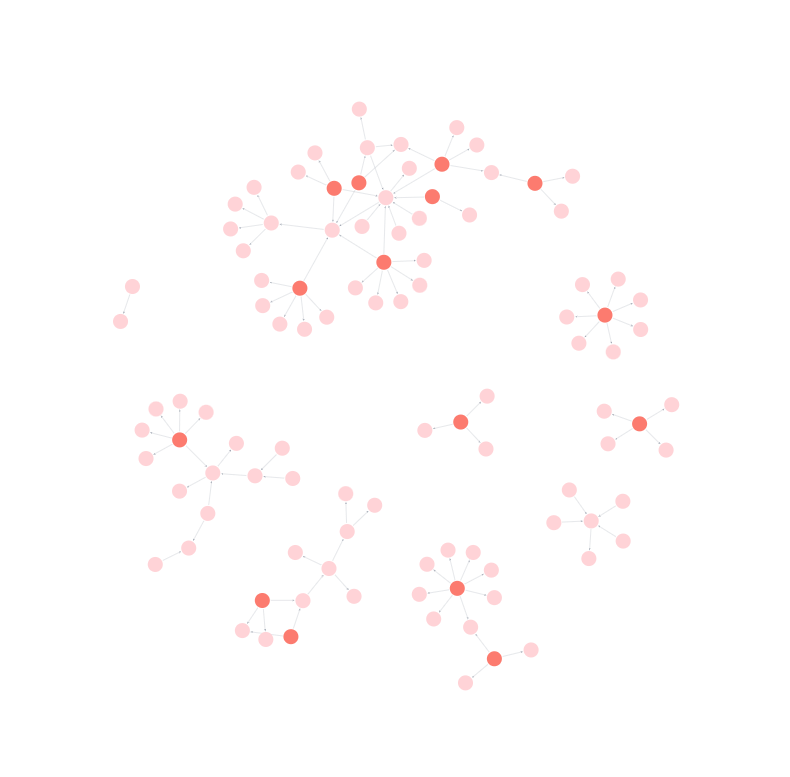

In [14]:
# After converting to graph documents
for i, doc in enumerate(graph_documents):
    print(f"Document {i}:")
    print(f"  Nodes: {doc.nodes}")
    print(f"  Relationships: {doc.relationships}")
    print("---")

Document 0:
  Nodes: [Node(id='Rag_Playground', type='Paper', properties={'title': 'RAG Playground', 'summary': 'An open-source framework for systematic evaluation of Retrieval-Augmented Generation (RAG) systems, implementing and comparing three retrieval approaches: naive vector search, reranking, and hybrid vector-keyword search, combined with ReAct agents using different prompting strategies.'}), Node(id='Retrieval-Augmented_Generation', type='Topic', properties={}), Node(id='Naive_Vector_Search', type='Topic', properties={}), Node(id='Reranking', type='Topic', properties={}), Node(id='Hybrid_Vector-Keyword_Search', type='Topic', properties={}), Node(id='React_Agents', type='Topic', properties={}), Node(id='Prompt_Engineering', type='Topic', properties={}), Node(id='Llama_3.1', type='Topic', properties={}), Node(id='Qwen_2.5', type='Topic', properties={})]
  Relationships: [Relationship(source=Node(id='Rag_Playground', type='Paper', properties={}), target=Node(id='Retrieval-Augmente

In [15]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template="""You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals.

    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.

    Here is the retrieved document:
    {document}

    Here is the user question:
    {question}
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "Do we have articles that talk about Prompt Engineering?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(
    f'Is our answer relevant to the question asked: {retrieval_grader.invoke({"question": question, "document": doc_txt})}'
)

Is our answer relevant to the question asked: {'score': 'yes'}


In [16]:
### Generate

from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Context: {context}
    Answer:
    """,
    input_variables=["question", "document"],
)

llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash-exp', temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "What are the most appropriate techniques for Prompt Engineering?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Based on the provided context, Chain of Thought and Tree of Thought are effective prompt engineering techniques. Additionally, using well-crafted prompts to infuse human experience into LLMs is also beneficial. Furthermore, Prompt Declaration Language (PDL) is a simple language that puts prompts at the forefront.



In [22]:
### Graph Generate

from langchain_core.prompts import PromptTemplate
from langchain_neo4j import GraphCypherQAChain
from langchain_openai import ChatOpenAI


cypher_prompt = PromptTemplate(
    template="""You are an expert at generating Cypher queries for Neo4j.
    Use the following schema to generate a Cypher query that answers the given question.
    Make the query flexible by using case-insensitive matching and partial string matching where appropriate.
    Focus on searching paper titles as they contain the most relevant information.

    Schema:
    {schema}

    Question: {question}

    Cypher Query:""",
    input_variables=["schema", "question"],
)


# QA prompt
qa_prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.
    Use the following Cypher query results to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise. If topic information is not available, focus on the paper titles.

    Question: {question}
    Cypher Query: {query}
    Query Results: {context}

    Answer:""",
    input_variables=["question", "query", "context"],
)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Chain
graph_rag_chain = GraphCypherQAChain.from_llm(
    cypher_llm=llm,
    qa_llm=llm,
    validate_cypher=True,
    graph=graph,
    verbose=True,
    return_intermediate_steps=True,
    allow_dangerous_requests=True,
    return_direct=True,
    cypher_prompt=cypher_prompt,
    qa_prompt=qa_prompt,
)

# Run
question = "What paper talks about RAG?"
generation = graph_rag_chain.invoke({"query": question})
print(generation)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Paper)
WHERE toLower(p.title) CONTAINS toLower("RAG")
RETURN p.title


> Finished chain.
{'query': 'What paper talks about RAG?', 'result': [{'p.title': 'RAG Playground'}, {'p.title': 'RepoRift: Enhancing Code Search with RAG and Agentic LLMs'}, {'p.title': 'Prompt-RAG: A Novel Approach to Enhance Generative LLMs in Niche Domains'}, {'p.title': 'RAG-Thief: An Agent-Based Automated Privacy Attack on RAG Applications'}], 'intermediate_steps': [{'query': 'cypher\nMATCH (p:Paper)\nWHERE toLower(p.title) CONTAINS toLower("RAG")\nRETURN p.title\n'}]}


In [27]:
### Composite Vector + Graph Generations

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.base import Chain


# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context from a vector store and a graph database to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Vector Context: {context}
    Graph Context: {graph_context}
    Answer:
    """,
    input_variables=["question", "context", "graph_context"],
)

llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash-exp', temperature=0)

# Example input data
# question = "What techniques are used for Multi-Agent? "
question = "What paper talk about RAG?"

In [28]:
# Get vector + graph answers
docs = retriever.invoke(question)

print(docs)

[Document(metadata={'pk': 455082184054145031, 'summary': 'We propose a natural language prompt-based retrieval augmented generation\n(Prompt-RAG), a novel approach to enhance the performance of generative large\nlanguage models (LLMs) in niche domains. Conventional RAG methods mostly\nrequire vector embeddings, yet the suitability of generic LLM-based embedding\nrepresentations for specialized domains remains uncertain. To explore and\nexemplify this point, we compared vector embeddings from Korean Medicine (KM)\nand Conventional Medicine (CM) documents, finding that KM document embeddings\ncorrelated more with token overlaps and less with human-assessed document\nrelatedness, in contrast to CM embeddings. Prompt-RAG, distinct from\nconventional RAG models, operates without the need for embedding vectors. Its\nperformance was assessed through a Question-Answering (QA) chatbot application,\nwhere responses were evaluated for relevance, readability, and informativeness.\nThe results show

In [29]:
vector_context = rag_chain.invoke({"context": docs, "question": question})

print(vector_context)

Several papers discuss Retrieval-Augmented Generation (RAG). One paper introduces Prompt-RAG, a vector embedding-free approach for niche domains. Another paper proposes RAG-DDR, a method for optimizing RAG systems using differentiable data rewards. Additionally, a paper explores the impact of design factors on RAG system performance.



In [30]:
graph_context = graph_rag_chain.invoke({"query": question})

print(graph_context)



> Entering new GraphCypherQAChain chain...


Generated Cypher:
cypher
MATCH (p:Paper)
WHERE toLower(p.title) CONTAINS toLower("RAG")
RETURN p.title, p.abstract, p.authors


> Finished chain.
{'query': 'What paper talk about RAG?', 'result': [{'p.title': 'RAG Playground', 'p.abstract': None, 'p.authors': None}, {'p.title': 'RepoRift: Enhancing Code Search with RAG and Agentic LLMs', 'p.abstract': None, 'p.authors': None}, {'p.title': 'Prompt-RAG: A Novel Approach to Enhance Generative LLMs in Niche Domains', 'p.abstract': None, 'p.authors': None}, {'p.title': 'RAG-Thief: An Agent-Based Automated Privacy Attack on RAG Applications', 'p.abstract': None, 'p.authors': None}], 'intermediate_steps': [{'query': 'cypher\nMATCH (p:Paper)\nWHERE toLower(p.title) CONTAINS toLower("RAG")\nRETURN p.title, p.abstract, p.authors\n'}]}


In [31]:
# Run the chain
composite_chain = prompt | llm | StrOutputParser()
answer = composite_chain.invoke(
    {"question": question, "context": vector_context, "graph_context": graph_context}
)

print(answer)

Several papers discuss RAG, including "Prompt-RAG," which is a vector embedding-free approach, and "RAG-DDR," which optimizes RAG systems using differentiable data rewards. Other papers include "RAG Playground", "RepoRift: Enhancing Code Search with RAG and Agentic LLMs", and "RAG-Thief: An Agent-Based Automated Privacy Attack on RAG Applications". Additionally, a paper explores the impact of design factors on RAG system performance.



In [51]:
### Hallucination Grader

# LLM
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash-exp', format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""
    You are a grader evaluating whether an answer is semantically grounded in and supported by a provided set of facts. Consider the semantic relationship and overall alignment between the facts and the answer, rather than focusing solely on exact matches or numeric values. Your goal is to provide a fair and accurate binary score.

    If the answer meaningfully relates to and aligns with the facts, assign a score of "yes." If the answer is unrelated to, contradicts, or cannot be reasonably inferred from the facts, assign a score of "no."

    Provide your binary score as a JSON object with a single key 'score' and no preamble, explanation, or additional text.

    Query:
    {query}

    Facts:
    {documents}

    Answer:
    {generation}
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"query": question, "documents": docs, "generation": generation})

{'score': 'yes'}

In [34]:
### Answer Grader

# LLM
llm = ChatGoogleGenerativeAI(model='gemini-1.5-pro', format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.

    Here is the answer:
    {generation}

    Here is the question: {question}
    """,
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [35]:
### Router

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatGoogleGenerativeAI(model='gemini-1.5-pro', format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are an expert at routing a user question to the most appropriate data source.
    You have three options:
    1. 'vectorstore': Use for questions about LLM agents, prompt engineering, and adversarial attacks.
    2. 'graphrag': Use for questions that involve relationships between entities, such as authors, papers, and topics, or when the question requires understanding connections between concepts.
    3. 'web_search': Use for all other questions or when current information is needed.

    You do not need to be stringent with the keywords in the question related to these topics.
    Choose the most appropriate option based on the nature of the question.

    Return a JSON with a single key 'datasource' and no preamble or explanation.
    The value should be one of: 'vectorstore', 'graphrag', or 'web_search'.

    Question to route:
    {question}""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

<ipython-input-35-a9011d96bfeb>:29: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


{'datasource': 'vectorstore'}


In [36]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

We'll implement these as a control flow in LangGraph.

In [70]:
from typing_extensions import TypedDict
from typing import List

### State


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
        graph_context: results from graph search
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]
    graph_context: str

    attempts: int


from langchain.schema import Document

### Nodes


def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents and graph context

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state.get("documents", [])
    graph_context = state.get("graph_context", "")

    # Composite RAG generation
    generation = composite_chain.invoke(
        {"question": question, "context": documents, "graph_context": graph_context}
    )

    attempts = state.get("attempts", 0)
    attempts += 1

    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "graph_context": graph_context,
        "attempts": attempts
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])  # Use get() with a default empty list

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Conditional edge


def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])

    if source["datasource"] == "graphrag":
        print("---TRYING GRAPH SEARCH---")
        graph_result = graph_search({"question": question})
        if graph_result["graph_context"] != "No results found in the graph database.":
            return "graphrag"
        else:
            print("---NO RESULTS IN GRAPH, FALLING BACK TO VECTORSTORE---")
            return "retrieve"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO VECTORSTORE RAG---")
        return "retrieve"
    elif source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def graph_search(state):
    """
    Perform GraphRAG search using Neo4j

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updated state with graph search results
    """
    print("---GRAPH SEARCH---")
    question = state["question"]

    # Use the graph_rag_chain to perform the search
    result = graph_rag_chain.invoke({"query": question})

    # Extract the relevant information from the result
    # Adjust this based on what graph_rag_chain returns
    graph_context = result.get("result", "")

    # You might want to combine this with existing documents or keep it separate
    return {"graph_context": graph_context, "question": question}


### Conditional edge


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"query": question, "documents": documents, "generation": generation}
    )
    grade = grade = score.get("score", "").lower()

    attempts = state['attempts']

    # Check hallucination
    if grade == "yes" or attempts == 5:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("graphrag", graph_search)

### Graph Build

In [71]:
# Set conditional entry point
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "retrieve": "retrieve",
        "graphrag": "graphrag",
    },
)

# Add edges
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("graphrag", "generate")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [72]:
# Compile
app = workflow.compile()

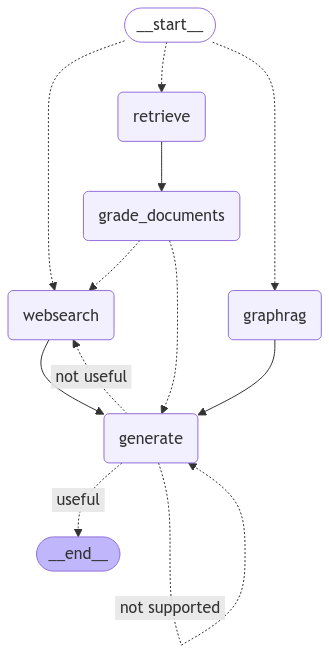

In [63]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [41]:
# Test
from pprint import pprint

inputs = {"question": "What are the types of Prompt Engineering?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What are the types of Prompt Engineering?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO VECTORSTORE RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Prompt engineering involves techniques such as fine-tuning the model on '
 'specific tasks, using natural language instructions, leveraging context and '
 'examples, and employing different prompt formats. Some types of prompt '
 'enginee

In [42]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint

inputs = {"question": "What is a Large Language Model?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What is a Large Language Model?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO VECTORSTORE RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Large Language Models (LLMs) are machine learning models that can understand '
 'and generate human language text. They are trained on huge datasets and use '
 'deep learning techniques. LLMs can perform various language tasks, such as '
 'answ

In [73]:
# Test
from pprint import pprint

inputs = {"question": "What paper talk about RAG?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What paper talk about RAG?
{'datasource': 'graphrag'}
graphrag
---TRYING GRAPH SEARCH---
---GRAPH SEARCH---


> Entering new GraphCypherQAChain chain...


Generated Cypher:
cypher
MATCH (p:Paper)
WHERE toLower(p.title) CONTAINS toLower("RAG")
RETURN p.title, p.abstract, p.authors


> Finished chain.
---GRAPH SEARCH---


> Entering new GraphCypherQAChain chain...


Generated Cypher:
cypher
MATCH (p:Paper)
WHERE toLower(p.title) CONTAINS toLower("RAG")
RETURN p.title, p.abstract, p.authors


> Finished chain.
'Finished running: graphrag:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
'Finished running: generate:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Several papers discuss RAG, including "RAG Playground," "RepoRift: Enhanc

In [84]:
from pprint import pprint

inputs = {"question": "What is Google Gemini 2.0?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What is Google Gemini 2.0?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Google Gemini 2.0 is a new AI model designed for the "agentic era" that '
 'offers faster speeds, enhanced reasoning, and seamless multimodal '
 'integration. It has new capabilities like native image generation, audio '
 'output, and the use of tools like Google Search and Maps. Developers can '
 'start building with this model in the Gemini API via Google AI Studio and '
 'Vertex AI.\n')
